# Neighbour Joining Tree for sWGA vs. gDNA

# Introduction

This notebook recreates [Supplementary Figure 3](https://figshare.com/ndownloader/files/38478530) from the [Pf7 paper](https://wellcomeopenresearch.org/articles/8-22) - a neighbour-joining tree (NJT) comparing selective whole-genome amplification **(sWGA)** with whole genome sequencing **(WGS)** samples.

The tree demonstrates the lack of bias due to amplification/sequencing methods in Pf7.

Unlike most of the other example notebooks in the Pf7 data resource, this notebook runs using predominantly R code rather than Python. The main reason for this is that the package used to build the NJT, ape, has better options for customising and visualising the tree than currently available Python libraries.

**This notebook should take approximately five minutes to run.**

## Neighbour Joining Trees
A neighbour joining tree, or NJT, is a type of distance-based tree used to visualise population structure for a set of samples. A tree will plot more closely related samples on nearby 'branches', while more distantly related samples appear farther apart in a tree.

A NJT makes use of a distance matrix, which contains information on how near/distant samples are in an evolutionary sense. In the case of the Pf7 data, this distance matrix was calculated using high-quality bi-allelic single nucleotide polymorphisms (SNPs) from across the Pf genome. A NJT is created by joining the closest samples (or **neighbours**) over and over until the final tree is built.

For this use case, a NJT is a good choice because it is less computationally expensive than other trees such as Maximum Likelihood while still being a robust method for analysing genetic structure. You can read the original paper on the method [here](https://academic.oup.com/mbe/article/4/4/406/1029664) and a more user-friendly guide to the concept [here](https://www.tenderisthebyte.com/blog/2022/08/31/neighbor-joining-trees/#:~:text=The%20method%20was%20first%20introduced,via%20an%20iterative%20clustering%20process.)

# Activate R magic
This notebook is running from a Python kernel so that we can load the MalariaGEN python package with a "pip install" command.

As mentioned, we need the rest of the notebook to run with R. To enable this, we activate **R magic commands**. This means that anytime a code cell starts with **"%%R"**, it will run R code within the cell.

In [1]:
# activate R magic
%load_ext rpy2.ipython

# Setup
Install the malariagen package.

In [2]:
!pip install -q --no-warn-conflicts malariagen_data

Load the required Python libraries

In [3]:
import malariagen_data
from ftplib import FTP
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from google.colab import drive

# Suppress FutureWarnings
# This surpresses a warning from pandas2ri.py when it uses iteritems() that occurs at a few points in the notebook
# The warning states that iteritems will be replaced by items() in the future
# It appears to be a bug in rpy2 that we can ignore for now
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # comment out this code if you would like to see the warnings

Install the required R packages

In [4]:
# This code block surpresses a long list of 'warnings' from rpy2 when installing R packages
# The 'warnings' apppear to be empty or contain progress messages for the installation
# For this reason, we surpress them to keep the notebook neater.
# If you want to see them, comment out this block.
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

In [5]:
%%R
install.packages("ape", lib = '/usr/local/lib/R/site-library')
install.packages("RcppCNPy", lib = '/usr/local/lib/R/site-library')
install.packages("reticulate", lib = '/usr/local/lib/R/site-library')

In [6]:
# Reset the logging level to its default value to show future warnings and errors
rpy2_logger.setLevel(logging.NOTSET)

Load the required R packages

In [7]:
%%R
library(ape)
library(RcppCNPy)
library(reticulate)

## Access the data
We need to load the Pf7 metadata...

In [8]:
# Load the Pf7 metadata
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()

...And the distance matrix (genetic distances between all 20,864 samples).

This available from a FTP (file transfer protocol) server. We log in to this server and make a copy of the distance matrix in our Google Colab space.

In [9]:
# Load the distance matrix
# Replace these values with your FTP server details
ftp_host = 'ngs.sanger.ac.uk'
ftp_file_path = '/production/malaria/Resource/34/Pf7_genetic_distance_matrix.npy'

# Create an FTP instance and connect to the server
ftp = FTP(ftp_host)
ftp.login()

# Change the current directory to the location of the file
ftp.cwd('/production/malaria/Resource/34/')  # Change to the root directory or your desired directory

# Download the file to Colab
with open('Pf7_genetic_distance_matrix.npy', 'wb') as file:
    ftp.retrbinary('RETR ' + ftp_file_path, file.write)

# Close the FTP connection
ftp.quit()

# Check if the file is downloaded successfully
import os
if os.path.exists('Pf7_genetic_distance_matrix.npy'):
    print('File downloaded successfully.')
else:
    print('File download failed.')


File downloaded successfully.


In [10]:
%%R
dist_fn <- (file = '/content/Pf7_genetic_distance_matrix.npy') # The path to our copy of the distance matrix

In [11]:
%%R
np <- import("numpy") # Import the python library numpy within an R environment

In [12]:
%%R
mean_distance_matrix = np$load(dist_fn) # Define the distance matrix

## Create a dataframe for the sample data in R
Until now we have been working in Python and R to read in the sample data (a python package) and the distance matrix (using Python and R commands).

We will need the sample data to be R-readable to continue to tree building.

In the following steps we use a conversion tool "rpy2.pandas2ri" to convert the pandas datframe sample_metadata to an R dataframe.

In [13]:
pandas2ri.activate()

In [14]:
r_dataframe = pandas2ri.py2rpy(sample_metadata)

In [15]:
robjects.globalenv['r_dataframe'] = r_dataframe #Add the R dataframe to our R environment
%R df_samples <- r_dataframe # change the dataframe name to something more informative
%R head(df_samples, 3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,1,Analysis_set,gDNA,1
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.85,1,Analysis_set,gDNA,1
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,86.46,1,Analysis_set,sWGA,0


## Begin the NJT Process
Set a colour for each sample type. Here we create a new column in df_samples, 'population_colour', which will contain the HEX code for blue if the sample type is gDNA, or red if the sample type is sWGA.

In [16]:
%%R
df_samples$population_colour <- ifelse(df_samples$`Sample type` == "gDNA", "#3182bd",
                                       ifelse(df_samples$`Sample type` == "sWGA", "#e31a1c", "NA"))

# A) Ghana, Upper East, 2015
To generate the first NJT of the figure, we must subset the metadata and the distance matrix to include only samples which meet the following criteria:
 - Passed Quality Control (QC), denoted as 'Analysis set'
 - From Ghana, Upper East administrative division
 - From 2015

In [17]:
%%R
# We combine the criteria using "&" to create a logical vector 'pass_samples'
# where each element refers to a row in the df_samples dataframe
# and evaluates to TRUE if all the conditions are met for that row, or FALSE otherwise.
pass_samples <- (
    df_samples$`Exclusion reason` == 'Analysis_set' & # We use backticks (`) around column names with spaces 'Exclusion reason', to ensure they are correctly recognized as column names.
    df_samples$Country == 'Ghana' &
    df_samples$`Admin level 1` == 'Upper East' &
    df_samples$Year == 2015
)
summary(pass_samples) # We have 225 samples that satisfy the criteria

   Mode   FALSE    TRUE 
logical   20639     225 


In [18]:
# How many samples do we have of each sample type?
%%R
aggregate(Sample ~ Country+`Sample type`, df_samples[pass_samples, ], FUN=length)

  Country Sample type Sample
1   Ghana        gDNA     61
2   Ghana        sWGA    164


#### Create a NJ tree object
We use the 'nj' command from ape on a subset of the distance matrix, defined as the 'TRUE' component of the logical vector we created earlier.

This should be a matrix of 225 x 225 samples.

In [19]:
%%R
tree = nj(mean_distance_matrix[pass_samples, pass_samples])

#### Plotting Functions for the NJT
Below are a series of functions which plot the NJT.

1. **computeEdgeGroupCounts**: This function creates a matrix which tracks the counts of groups associated with edges of the NJT. Edge is another word for branch within a tree. It requires a 'phylotree' object and a list of labels for groups 'labelgroups'.

In [20]:
%%R
computeEdgeGroupCounts <- function(phylotree, labelgroups) {

  labels <- phylotree$tip.label
  num_tips <- length(labels)
  edge_names <- unique(sort(c(phylotree$edge)))

  # This matrix will keep track of the group counts for each edge.
  edge_group_counts <- matrix(0, nrow=length(edge_names), ncol=length(unique(sort(labelgroups))))
  rownames(edge_group_counts) <- edge_names
  colnames(edge_group_counts) <- unique(labelgroups)

  # Init the leaf branches.
  sapply(1:num_tips, function(l) {
    edge_group_counts[as.character(l), as.character(labelgroups[phylotree$tip.label[l]])] <<- 1
  })

  # Sort edges by the value of the descendent
  # The first segment will contain the leaves whereas the second the branches (closer to leaves first).
  # We need to do this because leaves are numbered 1:num_tips and the branches CLOSER to the leaves
  # with higher numbers.
  edges <- phylotree$edge[order(phylotree$edge[,2]),]
  branches <- edges[num_tips:nrow(edges),]
  edges[num_tips:nrow(edges),] <- branches[order(branches[,1],decreasing=T),]
  invisible(apply(edges, 1, function(edge) {
    # Check if we are connecting a leaf.
    if(edge[2] <= num_tips) {
      e <- as.character(edge[1])
      g <- as.character(labelgroups[phylotree$tip.label[edge[2]]])
      edge_group_counts[e,g] <<- edge_group_counts[e,g] + 1
    }
    else {
      e1 <- as.character(edge[1])
      e2 <- as.character(edge[2])
      edge_group_counts[e1,] <<- edge_group_counts[e1,] + edge_group_counts[e2,]
    }
  }))
  return(edge_group_counts)
}


2. **assignMajorityGroupColorToEdges**: This function will colour the branches/edges of the tree according to which group makes up most of the samples associated with that branch/edge. It uses the edge_group_counts from the previous function, as well as the phylotree object, and a vector of group colours. In cases where there is an equal split of groups for a branch/edge, the colour assigned is grey.

In [21]:
%%R
assignMajorityGroupColorToEdges <- function(phylotree, edge_group_counts, groupcolors, equality_color="gray") {
  edge_colors <- apply(phylotree$edge, 1, function(branch) { # Make an empty vector
    e <- as.character(branch[2])
    major_group_index <- which.max(edge_group_counts[e,]) # Identify the group with the max count
    if(all(edge_group_counts[e,] == edge_group_counts[e,major_group_index])) # Assign grey if all counts equal
      return(equality_color)
    else
      return(groupcolors[colnames(edge_group_counts)[major_group_index]]) # Assign majority group colour if not
  })
  return(edge_colors)
}

3. **assignGroupColorToUniqueEdges**: This function is very similar to the above function. It differs in that rather than checking if group counts are equal, it checks if the 2nd highest group count is negative. This enables the function to identify edges with a clear majority group.

In [22]:
%%R
assignGroupColorToUniqueEdges <- function(phylotree, edge_group_counts, groupcolors, equality_color="gray") {
  edge_colors <- apply(phylotree$edge, 1, function(branch) { # Make an empty vector
    e <- as.character(branch[2])
    major_group_index <- which.max(edge_group_counts[e,]) # Identify the group with the max count
    if(sort(-edge_group_counts[e,])[2] < 0) # Check if the 2nd highest count is negative
      return(equality_color) # Return grey if so
    else
      return(groupcolors[colnames(edge_group_counts)[major_group_index]]) # Return majority group colour if not
  })
  return(edge_colors)
}

#### Create a dataframe with sample type + colour assignments

In [23]:
%%R
# Create df_pops_with_colours by removing duplicated rows based on sample_type and population_colour columns
df_pops_with_colours <- df_samples[!duplicated(df_samples[, c('Sample type', 'population_colour')]), c('Sample type', 'population_colour')]

# Display the resulting dataframe
df_pops_with_colours

    Sample type population_colour
0          gDNA           #3182bd
2          sWGA           #e31a1c
322         MDA                NA


In [24]:
%%R
colourings_population <- df_pops_with_colours$population_colour # create a vector of colour codes
names(colourings_population) <- df_pops_with_colours$`Sample type` # give each element in that vector a name - assigned from the corresponding sample type
colourings_population

     gDNA      sWGA       MDA 
"#3182bd" "#e31a1c"      "NA" 


#### Put all the functions into action

In [25]:
%%R
groups = as.factor(df_samples[pass_samples, 'Sample type'])
names(groups) = tree[3]$'tip.label'
counts = computeEdgeGroupCounts(tree, groups)
edge_colors = unlist(assignGroupColorToUniqueEdges(
    tree, counts, groupcolors=colourings_population, equality_color='gray'
))

#### Plot the NJT

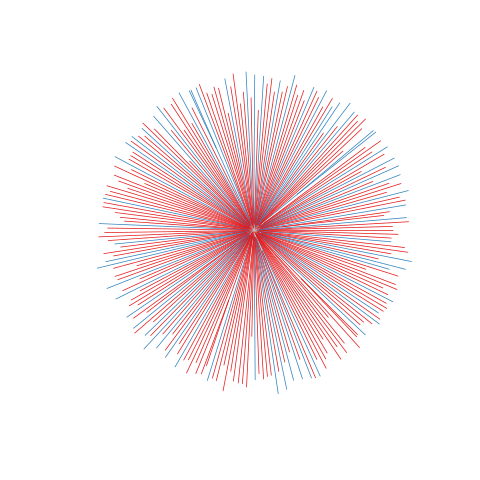

In [26]:
%%R
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)

**Figure legend**: Lack of bias in population structure due to use of sWGA from Ghana, Upper East, in 2015. Genome-wide unrooted neighbour-joining tree showing population structure where one subset of samples were sequenced from genomic DNA (gDNA, n = 61) material (shown as blue lines), and a second subset of samples were sequenced using sWGA material (n = 164, shown in red).

### Write the figure to a file

We can output this to a location in Google Drive

First we need to connect Google Drive by running the following:

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%R
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
pdf('/content/drive/My Drive/Ghana_UpperEast_2015.pdf')
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)
dev.off()

[1] 2


## Continue on to make the rest of the figure

# B) Kenya, Kilifi, 2007-2012

For the following three plots, we only need to re-run a section of the above code, in order to:
- Redefine pass_samples as our new subset of interest
- Remake the phylotree object 'tree' for our new subset
- Redefine 'groups' for the tree in relation to the new 'pass_samples'
- Replot the tree

This is because all the plotting functions and the sampletype:colour association dataframe above can be used for any NJT plot. The code blocks that change the plot are the four listed above.

#### Redfine pass_samples

In [27]:
%%R
# We combine the criteria using "&" to create a logical vector 'pass_samples'
# where each element refers to a row in the df_samples dataframe
# and evaluates to TRUE if all the conditions are met for that row, or FALSE otherwise.
pass_samples <- (
    df_samples$`Exclusion reason` == 'Analysis_set' & # We use backticks (`) around column names with spaces 'Exclusion reason', to ensure they are correctly recognized as column names.
    df_samples$Country == 'Kenya' &
    df_samples$`Admin level 1` == 'Kilifi' &
    df_samples$Year >= 2007 &
    df_samples$Year <= 2012 # Note we have a range of years included here
)
summary(pass_samples) # We have 373 samples that satisfy the criteria

   Mode   FALSE    TRUE 
logical   20491     373 


In [28]:
# How many samples do we have of each sample type?
%%R
aggregate(Sample ~ Country+`Sample type`, df_samples[pass_samples, ], FUN=length)

  Country Sample type Sample
1   Kenya        gDNA    151
2   Kenya        sWGA    222


#### Remake the tree object

In [29]:
%%R
tree = nj(mean_distance_matrix[pass_samples, pass_samples])

#### Redefine 'groups' for our current 'pass_samples' variable

In [30]:
%%R
groups = as.factor(df_samples[pass_samples, 'Sample type'])
names(groups) = tree[3]$'tip.label'
counts = computeEdgeGroupCounts(tree, groups)
edge_colors = unlist(assignGroupColorToUniqueEdges(
    tree, counts, groupcolors=colourings_population, equality_color='gray'
))

#### Plot the new NJT

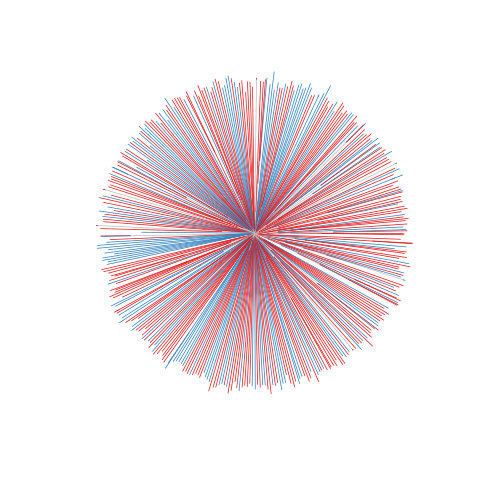

In [31]:
%%R
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)

**Figure legend**: Lack of bias in population structure due to use of sWGA from Kenya, Kilifi, between 2007 - 2012. Genome-wide unrooted neighbour-joining tree showing population structure where one subset of samples were sequenced from genomic DNA (gDNA, n = 151) material (shown as blue lines), and a second subset of samples were sequenced using sWGA material (n = 222, shown in red).

#### Write the figure to a file

If you have already mounted your Google Drive for the above plot, you do not need to run it again.

If you need to mount it again, uncomment the following code:

In [ ]:
# drive.mount('/content/drive')

In [ ]:
%%R
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
pdf('/content/drive/My Drive/Kenya_Kilifi_2007_2012.pdf')
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)
dev.off()

[1] 2


# C) Cambodia, Pursat, 2016

We will now repeat the above steps to generate a NJT in exactly the same way. This time we will look at samples from Cambodia, Pursat, in 2016.

In [32]:
%%R
# Generate a logical vector for this tree
pass_samples <- (
    df_samples$`Exclusion reason` == 'Analysis_set' & # We use backticks (`) around column names with spaces 'Exclusion reason', to ensure they are correctly recognized as column names.
    df_samples$Country == 'Cambodia' &
    df_samples$`Admin level 1` == 'Pursat' &
    df_samples$Year == 2016
)
summary(pass_samples) # We have 52 samples that satisfy the criteria

   Mode   FALSE    TRUE 
logical   20812      52 


In [33]:
# How many samples do we have of each sample type?
%%R
aggregate(Sample ~ Country+`Sample type`, df_samples[pass_samples, ], FUN=length)

   Country Sample type Sample
1 Cambodia        gDNA     30
2 Cambodia        sWGA     22


In [34]:
%%R
tree = nj(mean_distance_matrix[pass_samples, pass_samples])

In [35]:
%%R
groups = as.factor(df_samples[pass_samples, 'Sample type'])
names(groups) = tree[3]$'tip.label'
counts = computeEdgeGroupCounts(tree, groups)
edge_colors = unlist(assignGroupColorToUniqueEdges(
    tree, counts, groupcolors=colourings_population, equality_color='gray'
))

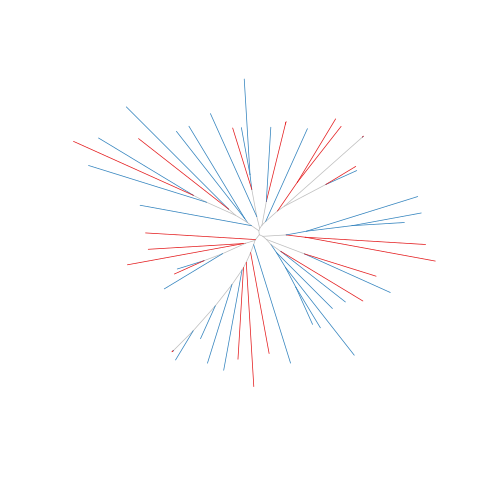

In [36]:
%%R
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)

**Figure legend**: Lack of bias in population structure due to use of sWGA from Cambodia, Pursat, in 2016. Genome-wide unrooted neighbour-joining tree showing population structure where one subset of samples were sequenced from genomic DNA (gDNA, n = 30) material (shown as blue lines), and a second subset of samples were sequenced using sWGA material (n = 22, shown in red).

#### Write the figure to a file

If you have already mounted your Google Drive for the above plot, you do not need to run it again.

If you need to mount it again, uncomment the following code:

In [ ]:
# drive.mount('/content/drive')

In [ ]:
%%R
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
pdf('/content/drive/My Drive/Cambodia_Pursat_2016.pdf')
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)
dev.off()

[1] 2


# D) Vietnam, Binh Phuoc, 2016

In [37]:
%%R
# Generate a logical vector for this tree
pass_samples <- (
    df_samples$`Exclusion reason` == 'Analysis_set' & # We use backticks (`) around column names with spaces 'Exclusion reason', to ensure they are correctly recognized as column names.
    df_samples$Country == 'Vietnam' &
    df_samples$`Admin level 1` == 'Binh Phuoc' &
    df_samples$Year == 2016
)
summary(pass_samples) # We have 61 samples that satisfy the criteria

   Mode   FALSE    TRUE 
logical   20803      61 


In [38]:
# How many samples do we have of each sample type?
%%R
aggregate(Sample ~ Country+`Sample type`, df_samples[pass_samples, ], FUN=length)

  Country Sample type Sample
1 Vietnam        gDNA     39
2 Vietnam        sWGA     22


In [39]:
%%R
tree = nj(mean_distance_matrix[pass_samples, pass_samples])

In [40]:
%%R
groups = as.factor(df_samples[pass_samples, 'Sample type'])
names(groups) = tree[3]$'tip.label'
counts = computeEdgeGroupCounts(tree, groups)
edge_colors = unlist(assignGroupColorToUniqueEdges(
    tree, counts, groupcolors=colourings_population, equality_color='gray'
))

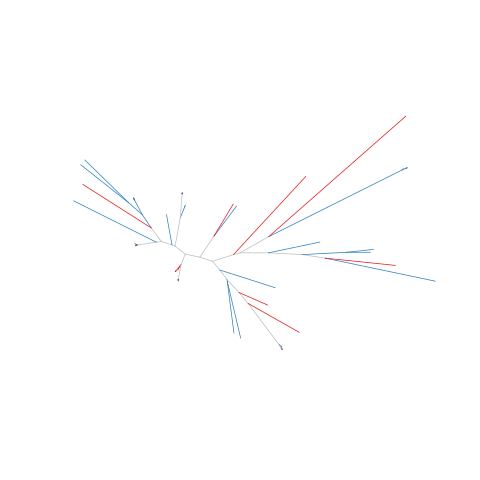

In [41]:
%%R
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)

**Figure legend**: Lack of bias in population structure due to use of sWGA from Vietnam, Binh Phuoc, in 2016. Genome-wide unrooted neighbour-joining tree showing population structure where one subset of samples were sequenced from genomic DNA (gDNA, n = 39) material (shown as blue lines), and a second subset of samples were sequenced using sWGA material (n = 22, shown in red).

#### Write the figure to a file

If you have already mounted your Google Drive for the above plot, you do not need to run it again.

If you need to mount it again, uncomment the following code:

In [ ]:
# drive.mount('/content/drive')

In [ ]:
%%R
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
pdf('/content/drive/My Drive/Vietnam_BinhPhuoc_2016.pdf')
plot.phylo(
    tree, type="unrooted",
    tip=df_samples[pass_samples, 'population_colour'],
    edge.color=unlist(edge_colors),
    show.tip.label=FALSE,
)
dev.off()

[1] 2


**Notebook Complete!**
Now you should have four PDF files corresponding to the four panels of supplementary Figure 3 in the Pf7 paper.